In [95]:
# Hyperparameters
test_results = True
T = 15
N = 10
n_from_index = 0 # How distant the first point is

In [96]:
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator
from casadi import *

import utils
from utils import get_position, my_odometry


In [97]:
plt.rcParams['figure.figsize'] = [7, 7]

In [98]:
#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

In [99]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
    robot_speed=1.0,
)

In [100]:
start_from_trajectory = True

# Trick to let the trajectory extractor see the whole line
env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], pi/2]

In [101]:
dt = 1.0 / env.frame_rate

In [102]:
env.reset()
traj = utils.get_trajectory(env, samples=500, method="distance", last_value_distance=1.035)

/home/giulio/prog/duckrace/utils.py:316: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


In [103]:
if start_from_trajectory:
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]
    # Why double? Good question
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], pi/2]

In [104]:
pose = get_position(env)
pose

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

Text(1.9486294618007634, 1.9308421914242628, '|---------|')

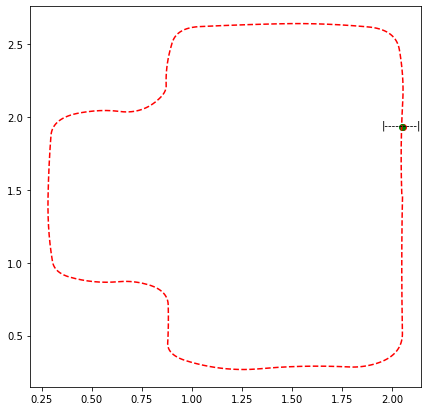

In [105]:
from scipy import spatial
distance,index = spatial.KDTree(traj).query([pose.x, pose.y])
index += n_from_index
startpoint = (traj[index,0], traj[index,1])
plt.plot(*traj.T, "r--")
plt.scatter(pose.x, pose.y, c="r")
plt.scatter(traj[index,0], traj[index,1], c="g")
plt.text(startpoint[0]-0.1, startpoint[1], '|'+'-'*9+'|')

In [106]:
f"Samples must be at least: {np.round(np.sum( np.sqrt(np.sum( np.diff(traj, axis=0)**2, axis=1 )) ) / (0.6*dt))}"

'Samples must be at least: 376.0'

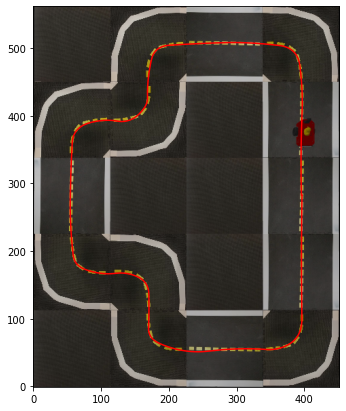

In [107]:
utils.show_on_map_array(env, traj[:,:2])

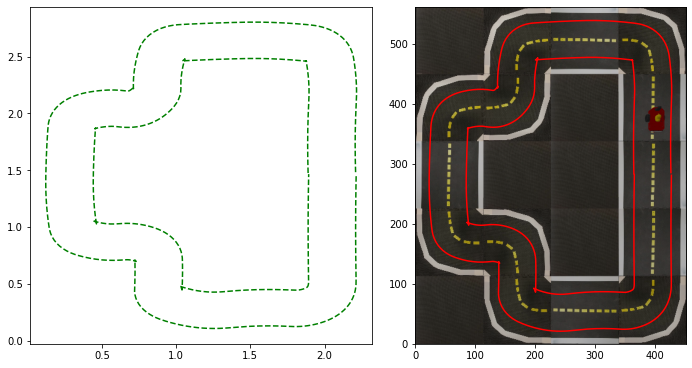

In [108]:
inside, outside = utils.get_border(traj, distance=0.16)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AB""")
ax_dict["A"].plot(*inside.T, "g--")
ax_dict["A"].plot(*outside.T, "g--")
utils.show_on_map_array(env, inside, fig=ax_dict["B"])
utils.show_on_map_array(env, outside, fig=ax_dict["B"])

In [109]:
get_position(env)

Position(x=2.0549999999999997, y=1.9297064071170351, theta=1.5707963267948966)

In [110]:
# Compute the angle between every consecutive points in traj
angles = np.zeros(traj.shape[0])
angles[:-1] = np.arctan2(traj[1:,1]-traj[:-1,1], traj[1:,0]-traj[:-1,0])
angles[-1] = np.arctan2(traj[0,1]-traj[-1,1], traj[0,0]-traj[-1,0])

In [111]:
# Add angles to traj
traj = np.concatenate((traj, angles.reshape(-1,1)), axis=1)

In [112]:
traj[index]

array([2.04862946, 1.93084219, 1.54813545])

In [113]:
index = DM(index)
traj = DM(traj)

Initialize states, inputs, and system dynamic equation

In [114]:
pose = get_position(env)

In [115]:
N_MPC = 10

delay = round(0.15/dt)
u_delay0 = DM(np.zeros((2, delay)))
# N += delay

# Initial reference point
r0 = repmat(traj[index, :2].T, 1, N_MPC+1)
# Initial reference angles
t0 = repmat(traj[index, 2].T, 1, N_MPC+1)

# With preview
# Initial reference point
r0 = traj[index:index+N_MPC+1, :2].T
t0 = traj[index:index+N_MPC+1, 2].T

In [116]:
F = utils.model_F(dt=dt)

In [117]:
from collections import namedtuple
Line = namedtuple('Line', 't x y theta')
finish_line = Line(300, pose.x, pose.y, pose.theta) #2.2 same as start

In [118]:
# K nearest neighbors
K = 40

# Number of points to consider for track bound constraints
TB = 2

In [119]:
opti = Opti()

x = opti.variable(5,N+1)    # States with dimension (n_x, prediction_horizon+1) (x(0),...,x(N+1))
u = opti.variable(2,N)      # Inputs with dimension (n_u, prediction_horizon) (u(0),...,u(N))
l = opti.variable(K)      # Lambda of convex hull
z = opti.variable(1,1)      # z of the paper
x0 = opti.parameter(5,1)    # Parameter to set the initial state conditions (x(0))
D = opti.parameter(5,K)     # Nearest neighbors
J = opti.parameter(1, K)    # A matrix time, iteration with the old states
t_to_N = opti.parameter(1, N-1)  # Next t time steps
central_line = opti.parameter(2, TB)  # Next t time steps

def h(x):
   # return 1 if it gets across the finish line
   # finish line is defined as the area where t is enough and y > y_finish
   return if_else(logic_and(t_to_N, logic_and(x[1,:]>=finish_line.y, mod(x[2,:], 2*pi)==finish_line.theta)), 0, 1)

obj = sum2(h(x[:3,:N-1])) + J@l

opti.minimize(obj)

# Constraints Definition

# 1) System dynamics constraint over the prediction horizon
for k_ in range(0,N):
   opti.subject_to(x[:,k_+1]==F(x[:,k_],u[:,k_])) # No delay
    
# 2) Additional states/inputs constraints 
opti.subject_to(vec(u) <= 1)
opti.subject_to(vec(u) >= 0)
# 3) Force the state variable at instant 0 to be equal to the parameter value containing x0 value
opti.subject_to(x[:,0] == x0)
# 4) Set the convex hull constraints
opti.subject_to(l >= 0)
opti.subject_to(sum1(l) == 1)
opti.subject_to(D@l == x[:,N])
# opti.subject_to(pow(x[0,:TB]-central_line[0,:], 2) + pow(x[1,:TB]-central_line[1,:], 2) < 0.25)


opti.set_value(x0,[pose.x, pose.y, pose.theta, 0, 0]) # Set the initial x0 value

# Ipopt
opts = dict()
opts["ipopt.print_level"] = 0
opts["print_time"] = False
opti.solver('ipopt',opts)


## LMPC

In [120]:
# This instruction transfom all the Opti problem defined above into a callable function
M = opti.to_function('M',[x0, D, J, t_to_N, central_line],[u[:,0], l],['x0', 'D', 'J', 't_to_N', 'central_line'],['u_opt', "lambda"])

### Loop 0

In [121]:
# First loop
Mpc = Function.load('M.casadi')


# MPC loop
F = utils.model_F(dt=dt)
X_log = np.empty((5,0))
U_log = np.empty((2,0))

x = [pose.x, pose.y, pose.theta, 0, 0]
r = r0
tr = t0
idx = index
u_delay = u_delay0

kdtree = spatial.KDTree(traj[:, :2])

t = 0
while True:
    u = Mpc(x, r, tr, u_delay, 100, 5e-4, 1, 1e-3)

    U_log = np.column_stack((U_log, u))
    X_log = np.column_stack((X_log, x))

    u_delay = np.column_stack((u_delay, u))[:, -delay:]

    # simulate
    x = F(x,u)

    distance = (traj[idx, 0] - x[0])**2 + (traj[idx, 1] - x[1])**2

    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    if idx+N_MPC+1 < traj.shape[0]:
        r = traj[idx:idx+N_MPC+1, :2].T
        tr = traj[idx:idx+N_MPC+1, 2].T
    else:
        r = vertcat(traj[idx:, :2], traj[:idx+N_MPC+1-traj.shape[0], :2]).T
        tr = vertcat(traj[idx:, 2], traj[:idx+N_MPC+1-traj.shape[0], 2]).T

    if traj[idx, 1] >= finish_line.y and t >= finish_line.t:
        break
    t += 1



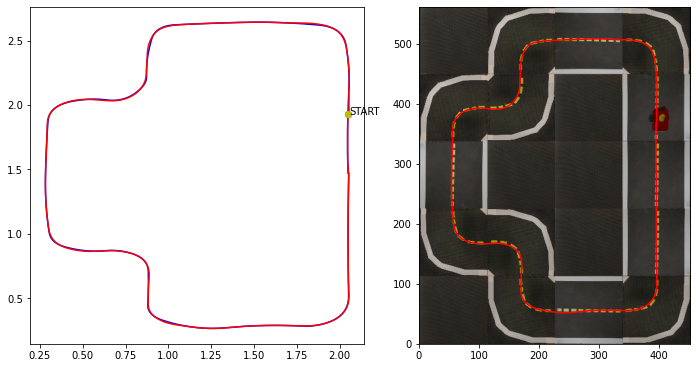

In [122]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [123]:
# all_points: [x, y, theta, v, w, steps to arrive]
all_points = X_log
X_log_orig = X_log
first_loop_len = all_points.shape[1]
all_points = np.vstack((all_points, np.arange(first_loop_len)[::-1]))
all_points_orig = all_points
x_orig = x

### Loop > 0

In [124]:
from sklearn.neighbors import NearestNeighbors

In [125]:

from IPython import display as ipythondisplay

In [126]:
traj[:,:2]

DM(
[[2.0496, 1.47101], 
 [2.04922, 1.48667], 
 [2.04886, 1.5023], 
 [2.04853, 1.51792], 
 [2.04822, 1.53351], 
 [2.04794, 1.54908], 
 [2.04768, 1.56463], 
 [2.04744, 1.58015], 
 [2.04723, 1.59565], 
 [2.04704, 1.61113], 
 [2.04688, 1.62658], 
 [2.04674, 1.64201], 
 [2.04662, 1.65742], 
 [2.04653, 1.6728], 
 [2.04646, 1.68817], 
 [2.04642, 1.70351], 
 [2.0464, 1.71882], 
 [2.0464, 1.73412], 
 [2.04643, 1.74939], 
 [2.04648, 1.76463], 
 [2.04655, 1.77986], 
 [2.04665, 1.79506], 
 [2.04678, 1.81024], 
 [2.04693, 1.82539], 
 [2.0471, 1.84053], 
 [2.04729, 1.85564], 
 [2.04751, 1.87072], 
 [2.04776, 1.88579], 
 [2.04802, 1.90083], 
 [2.04831, 1.91585], 
 [2.04863, 1.93084], 
 [2.04897, 1.94581], 
 [2.04933, 1.96076], 
 [2.04972, 1.97569], 
 [2.05013, 1.99059], 
 [2.05057, 2.00547], 
 [2.05103, 2.02033], 
 [2.05151, 2.03516], 
 [2.05202, 2.04998], 
 [2.05255, 2.06476], 
 [2.0531, 2.07953], 
 [2.05368, 2.09427], 
 [2.05428, 2.10899], 
 [2.05483, 2.12374], 
 [2.05527, 2.13856], 
 [2.05558, 2.

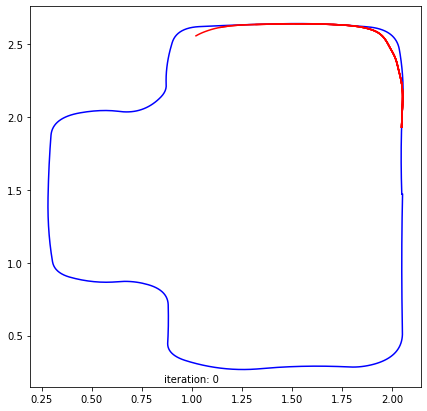

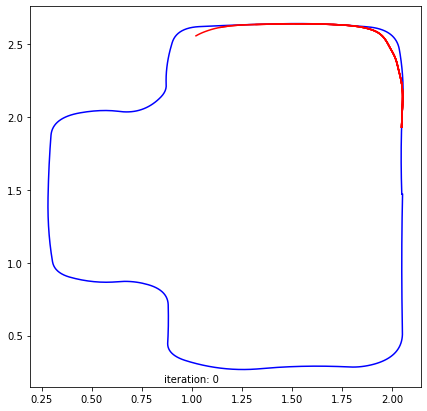

In [127]:
n_iterations = 2

real_time_plot = True

# For debugging
X_log = X_log_orig
# X_log[2,:] = (X_log_orig[2,:]+np.pi) % (2*np.pi) - np.pi
all_points = all_points_orig
# all_points[2,:] = (all_points_orig[2,:]+np.pi) % (2*np.pi) - np.pi
last_iterations = all_points
x = x_orig

F = utils.model_F(dt=dt)

if idx+N > all_points.shape[1]:
    idx = all_points.shape[1] - idx

Js = []
idxs = []
plain_loops = []

plt.plot(traj[:,0], traj[:,1], "b")
kdtraj = spatial.KDTree(traj[:, :2])
traj_len = traj.shape[0]

for iteration in range(n_iterations):
    last_loop = X_log
    X_log = np.empty((5,0))
    U_log = np.empty((2,0))

    # Normalize the angles
    # Overfit the starting angle to avoid normalization problems ;)
    x[2] = mod(x[2]+pi, 2*pi)-pi

    # x = [pose.x, pose.y, pose.theta, 0, 0]
    # idx = int(index)

    kdtree = spatial.KDTree(last_loop[:2, :200].T)
    nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(last_iterations[:2, :200].T)
    _,idx = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
    t = 0
    print("Iteration: ", iteration)
    plt.text(1, 0.2,"iteration: "+str(iteration), ha='center', va='center')
    while True:
        distances, indices = nbrs.kneighbors([last_loop[:2, (idx+N)%last_loop.shape[1]].T])
        indices = indices.reshape(-1)
        
        if t == 0:
            D = last_iterations[:-1, indices]
            J = last_iterations[-1, indices].reshape(-1)
        else:
            S = last_iterations[:, indices]@l
            distances, indices = nbrs.kneighbors(np.array(S[:2].T))
            indices = indices.reshape(-1)
            D = last_iterations[:-1, indices]
            J = last_iterations[-1, indices].reshape(-1)

        Js.append(J)
        idxs.append(idx)
        _, traj_idx = kdtraj.query(np.array([x[0], x[1]]).reshape(-1))
        u, l = M(x, DM(D[:, :]), DM(J)/600, (np.arange(t, t+N-1)>=finish_line.t).T, traj[traj_idx:(traj_idx+TB)%traj_len, :2].T)

        U_log = np.column_stack((U_log, u))
        X_log = np.column_stack((X_log, x))

        # simulate
        x = F(x,u)
        # x[2] = mod(x[2]+pi, 2*pi)-pi

        _,idx_new = kdtree.query(np.array([x[0], x[1]]).reshape(-1))
        if idx_new >= idx:
            idx = idx_new
            if idx+N > traj.shape[0]:
                idx = traj.shape[0] - idx
        
        if x[1] >= finish_line.y and t >= finish_line.t:
            break
        t += 1
        if t%10 == 0 and real_time_plot:
            plt.plot(*X_log[:2,:], c=['r', 'g', 'y'][iteration%3])
            ipythondisplay.clear_output(wait=True)
            ipythondisplay.display(plt.gcf())
        # if t == 100:
        #     break
        if t == 150:
            # Now it can see all the points
            kdtree = spatial.KDTree(last_loop[:2, :].T)
            last_iterations[2, :100] = last_iterations[2, :100] + 2*np.pi
            nbrs = NearestNeighbors(n_neighbors=K, algorithm='ball_tree').fit(last_iterations[:2, :].T)
    last_points = X_log
    last_points = np.vstack((last_points, np.arange(last_points.shape[1])[::-1]))

    plain_loops.append(X_log)

    # Here only if use 1 iteration in the past
    last_iterations = last_points

    all_points_len = all_points.shape[1]
    if all_points_len > last_points.shape[1]:
        last_points = np.pad(last_points, ((0,0), (0, all_points_len-last_points.shape[1])), 'constant', constant_values=(0,0))
    if all_points_len < last_points.shape[1]:
        all_points = np.pad(all_points, ((0,0), (0, last_points.shape[1]-all_points_len)), 'constant', constant_values=(0,0))
    all_points = np.hstack((all_points, last_points))

Text(0, 0.5, 'Time to finish [s]')

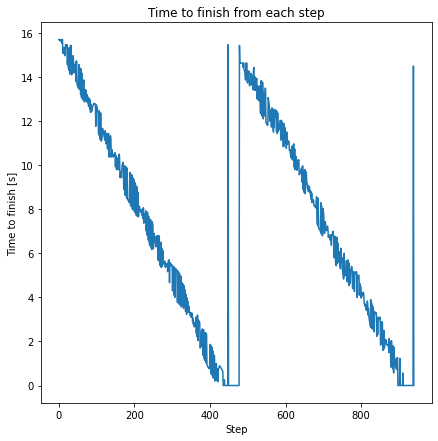

In [76]:
plt.plot(np.min(Js,axis=1)*dt, label="Time to finish")
plt.title("Time to finish from each step")
plt.xlabel("Step")
plt.ylabel("Time to finish [s]")

In [77]:
[loop.shape[1]*dt for loop in plain_loops]

[15.966666666666667, 15.366666666666667]

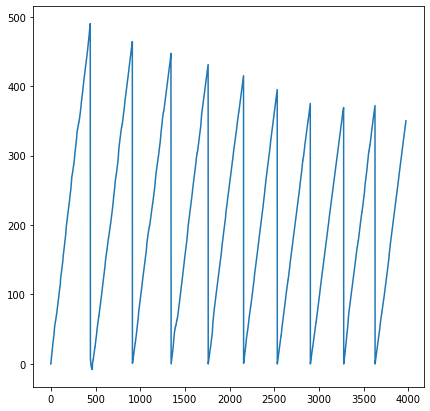

In [35]:
plt.plot(idxs)

In [36]:
xs = np.concatenate([loop[0,:] for loop in plain_loops])
ys = np.concatenate([loop[1,:] for loop in plain_loops])

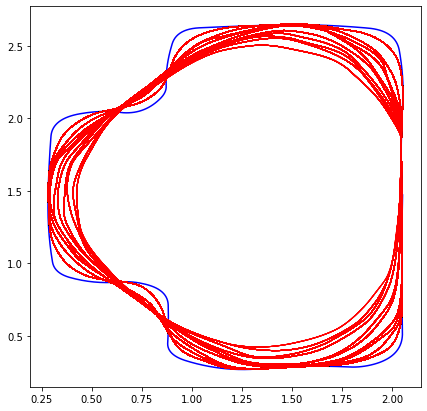

In [37]:
save_video = True

if save_video:
    from matplotlib.animation import FuncAnimation

    ratio = 10
    fig,ax = plt.subplots()

    def init():
        background = ax.plot(traj[:,0], traj[:,1], "b", zorder=0)
        return background

    def animate(i):
        line, = ax.plot(xs[:int(i*ratio)], ys[:int(i*ratio)], color='red', lw=1)
        return line

    ani = FuncAnimation(fig, animate, init_func=init, interval=(1/env.frame_rate)*ratio*1e3, blit=False, repeat=True, frames=int(xs.shape[0]/ratio))
    ani.save("assets/lmpc.mp4", writer='ffmpeg', dpi=300)

In [38]:
from IPython.display import Video

Video("assets/lmpc.mp4", width=600)

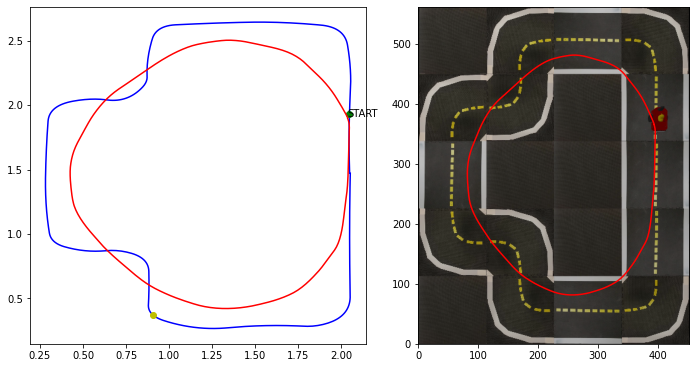

In [39]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax_dict = fig.subplot_mosaic("""AC
        AC""")
ax_dict["A"].text(X_log[0,0], X_log[1,0], 'START')
ax_dict["A"].plot(traj[:,0], traj[:,1], "b")
ax_dict["A"].plot(traj[index,0], traj[index,1], 'go')
ax_dict["A"].plot(X_log[0,:], X_log[1,:], "r")
ax_dict["A"].plot(traj[idx, 0], traj[idx,1], 'yo')
# ax_dict["B"].plot(np.arange(len(errors))*dt, np.sqrt(errors))
utils.show_on_map_array(env, np.array([X_log[0,:], X_log[1,:]]).T, fig=ax_dict["C"])

In [64]:
np.rad2deg(X_log[2,0])%360

108.93321954975691

### Gym simulation

The MPC does not consider the delay yet!

In [65]:
record = True

if record:
    import imageio
    import cv2

    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], X_log[2,0]%(2*np.pi)]
    env.reset()
    env.unwrapped.start_pose = [[0.3, 0, 0.41029359288296474], X_log[2,0]%(2*np.pi)]
    pose = get_position(env)
    images = []
    positions = []
    odoms = [pose]
    actions = [[0,0]]*10
    v0 = 0
    w0 = 0
    for action in U_log.T:
        env.step(action)
        positions.append(get_position(env))
        img = env.render(mode='rgb_array')
        img = cv2.resize(img, dsize=(400, 300), interpolation=cv2.INTER_CUBIC)
        images.append(img)

        p, v0, w0 = my_odometry(action, odoms[-1].x, odoms[-1].y, odoms[-1].theta, v0, w0, dt=dt)
        odoms.append(p)
        actions.append(action)

    imageio.mimsave("assets/lmpc_run.gif", images, format='GIF', fps=env.frame_rate)

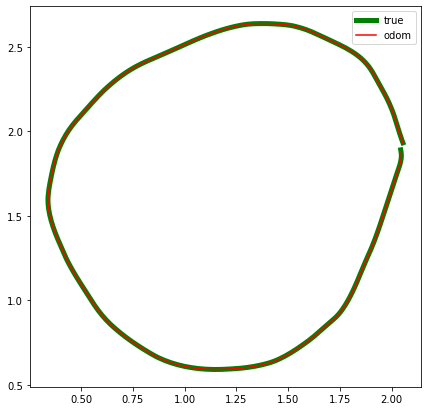

In [66]:
if record:
    plt.plot(*np.array([[p.x, p.y] for p in positions]).T, c='g', label='true', linewidth=5)
    plt.plot(*np.array([[p.x, p.y] for p in odoms]).T, c='r', label='odom')
    plt.legend()

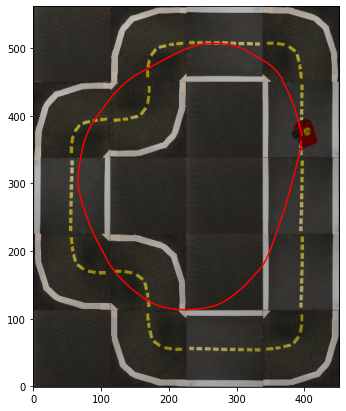

In [67]:
if record:
    utils.show_on_map(env, positions)

In [68]:
from IPython.display import HTML, display
# Trick to prevent cache use
display(HTML('<img src="assets/lmpc_run.gif?%d" width="750" align="center">' % np.random.randint(10)))